## Infosys Internship - COCO Dataset Processing
This notebook processes the COCO dataset, loading annotations and performing keypoint analysis.

## Importing required libraries

In [49]:
#Importing required libraries

import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import random
from skimage import io

## Configuration for the person json file

In [50]:
#Path to your COCO annotation file - json file

ANNOTATION_FILE = r"D:\Documents_New\coco2017_subset\coco2017_subset\annotation_subset\person_keypoints_train2017_subset.json"

#Folder where the corresponding images are stored

IMAGE_FOLDER = r"D:\Documents_New\coco2017_subset\coco2017_subset\train2017"

## Loading Dataset

In [51]:
#Initializing COCO API for instance annotations

coco = COCO(ANNOTATION_FILE)

loading annotations into memory...
Done (t=4.20s)
creating index...
index created!


In [52]:
#Getting the images IDs

img_ids = coco.getImgIds()
if not img_ids:
    raise ValueError("No images found in the annotation file!")

In [53]:
#Loading the first image from the dataset

img_data = coco.loadImgs(img_ids[1])[0]

In [54]:
#Constructing the image path and load it using OpenCV

img_path = os.path.join(IMAGE_FOLDER, img_data['file_name'])
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

## Plotting the image

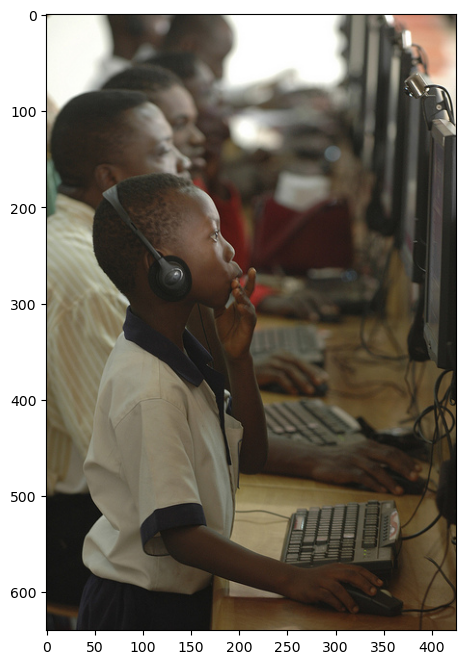

In [55]:
#Converting image from BGR to RGB

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(image)

In [56]:
# Getting all category IDs
category_ids = coco.getCatIds()

# Loading category names
categories = coco.loadCats(category_ids)

# Extracting names
class_names = [category['name'] for category in categories]

print("Classes in the dataset:", class_names)

Classes in the dataset: ['person']


## Configuration for the whole dataset

In [57]:
#Path to your COCO annotation file which includes all classes- json file

ANNOTATION_FILE_1 = r"D:\Documents_New\coco2017_subset\coco2017_subset\annotation_subset\instances_train2017_subset.json"

#Folder where the corresponding images are stored

IMAGE_FOLDER = r"D:\Documents_New\coco2017_subset\coco2017_subset\train2017"

In [58]:
#Initializing COCO API for instance annotations

coco1 = COCO(ANNOTATION_FILE_1)

loading annotations into memory...
Done (t=7.44s)
creating index...
index created!


In [59]:
# Get all category IDs and their names
category_ids = coco1.getCatIds()
categories = coco1.loadCats(category_ids)
category_names = {cat['id']: cat['name'] for cat in categories}

# Get the number of classes
num_classes = len(category_ids)

# Get the total number of images
img_ids = coco1.getImgIds()
num_images = len(img_ids)

# Print total counts
print(f"Number of classes: {num_classes}")
print(f"Number of images: {num_images}")

# Dictionary to store the number of images per class
class_image_count = {}

# Count the number of images for each class
for cat_id in category_ids:
    img_ids = coco1.getImgIds(catIds=[cat_id])  # Get images containing this class
    class_image_count[category_names[cat_id]] = len(img_ids)

# Convert dictionary to DataFrame
df = pd.DataFrame(list(class_image_count.items()), columns=['Category Name', 'Number of Images'])

# Ensure all rows are displayed
pd.set_option('display.max_rows', None)

# Display the table
print("\nNumber of images per class:")
print(df)

Number of classes: 80
Number of images: 29571

Number of images per class:
     Category Name  Number of Images
0           person             15978
1          bicycle               808
2              car              3063
3       motorcycle               857
4         airplane               781
5              bus               951
6            train               872
7            truck              1572
8             boat               772
9    traffic light               967
10    fire hydrant               432
11       stop sign               458
12   parking meter               176
13           bench              1354
14            bird               826
15             cat              1064
16             dog              1149
17           horse               767
18           sheep               381
19             cow               463
20        elephant               528
21            bear               231
22           zebra               485
23         giraffe               644


## EDA on the dataset

## Basic High Level Information

In [60]:
# Get dataset statistics
num_images = len(coco1.dataset['images'])
num_boxes = len(coco1.dataset['annotations'])
num_classes = len(coco1.dataset['categories'])

# Extract image dimensions (height & width)
image_heights = [img['height'] for img in coco1.dataset['images']]
image_widths = [img['width'] for img in coco1.dataset['images']]

# Compute statistics for height and width
max_height = max(image_heights)
min_height = min(image_heights)
avg_height = sum(image_heights) // num_images

max_width = max(image_widths)
min_width = min(image_widths)
avg_width = sum(image_widths) // num_images

# Print dataset summary
print(f"Dataset Name: {ANNOTATION_FILE_1.split(os.sep)[-1]}")
print(f"Number of images: {num_images}")
print(f"Number of bounding boxes: {num_boxes}")
print(f"Number of classes: {num_classes}")

Dataset Name: instances_train2017_subset.json
Number of images: 29571
Number of bounding boxes: 212806
Number of classes: 80


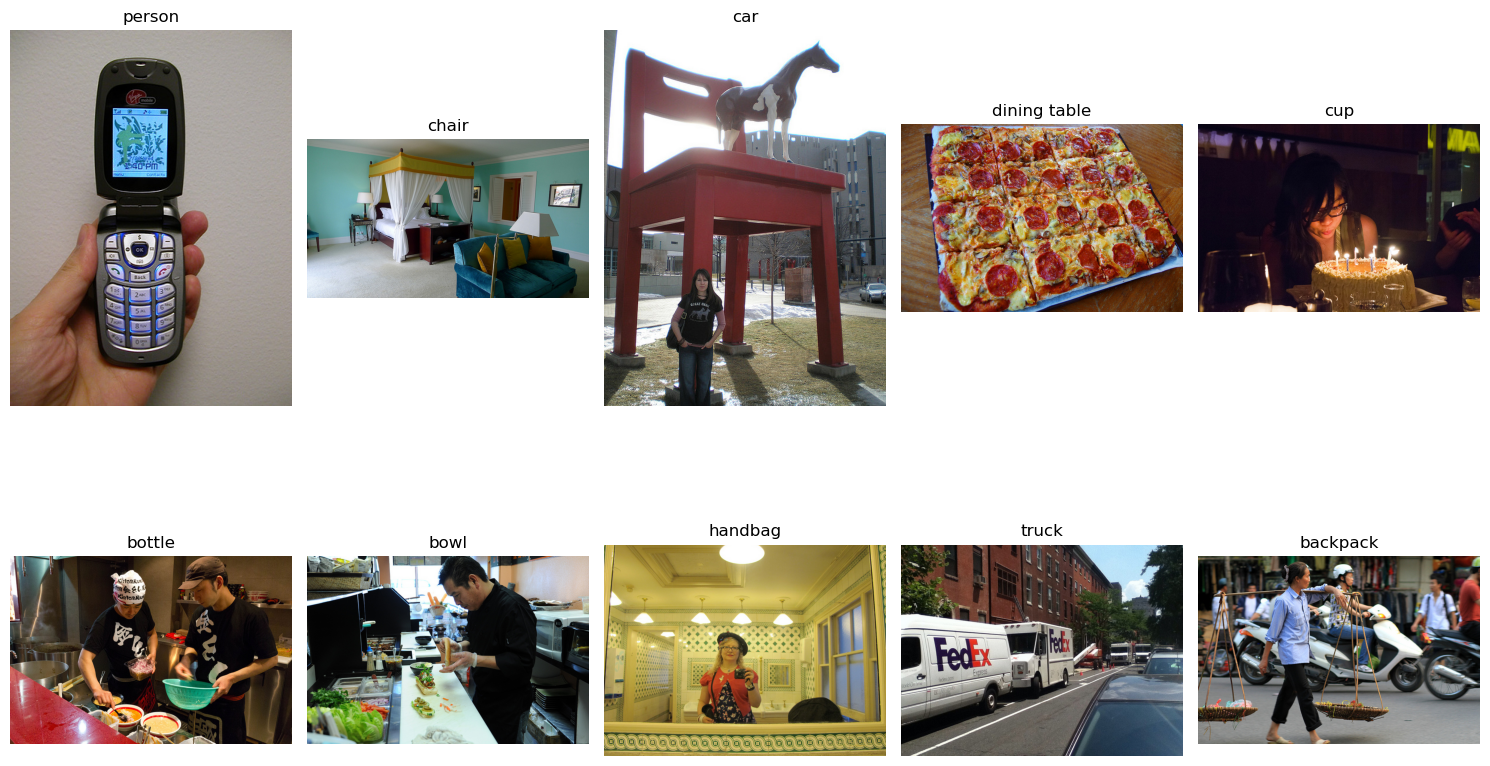

In [61]:
# Count images per class
class_image_count = {cat_id: len(coco1.getImgIds(catIds=[cat_id])) for cat_id in category_ids}

# Sort categories by number of images and get the top 10
top_classes = sorted(class_image_count.items(), key=lambda x: x[1], reverse=True)[:10]

# Load and display one image from each of the top 10 classes
plt.figure(figsize=(15, 10))

for i, (cat_id, _) in enumerate(top_classes):
    img_ids = coco1.getImgIds(catIds=[cat_id])
    if not img_ids:
        continue
    random_img_id = random.choice(img_ids)  # Randomly pick an image from the class
    img_data = coco1.loadImgs(random_img_id)[0]
    img_path = os.path.join(IMAGE_FOLDER, img_data['file_name'])
    image = io.imread(img_path)
    
    # Plot image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(category_names[cat_id])

plt.tight_layout()
plt.show()

## Distribution of objects across images

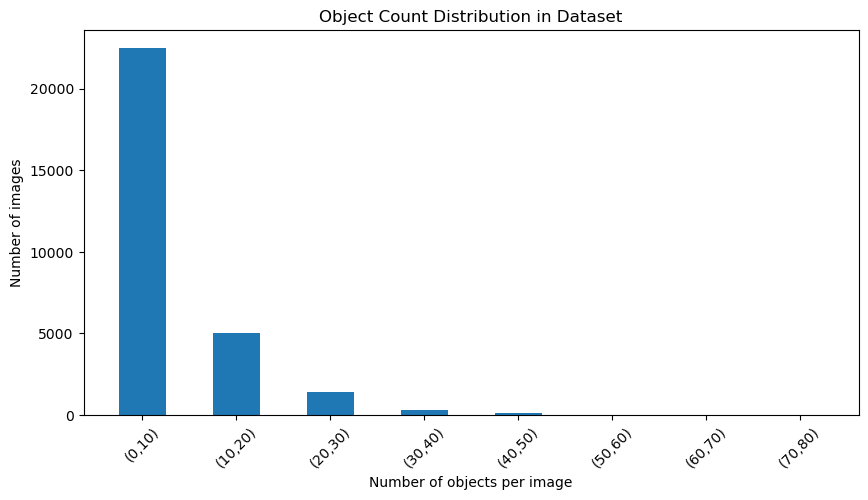

Number of images with at least one bounding box: 29315
Min number of boxes per image: 1
Max number of boxes per image: 78
Avg number of boxes per image: 7


In [62]:
# Mapping "image id" to "number of boxes"
img2nboxes = {}

for ann in coco1.dataset['annotations']:
    img_id = ann['image_id']
    img2nboxes[img_id] = img2nboxes.get(img_id, 0) + 1  

# Convert to list for analysis
nboxes_list = list(img2nboxes.values())

# Compute statistics
min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = sum(nboxes_list) // len(nboxes_list)

# Histogram binning for object distribution per image
out = pd.cut(nboxes_list, bins=np.arange(0, max_nboxes + 10, 10), include_lowest=True)
counts = out.value_counts().values
labels = [(int(i.left), int(i.right)) for i in out.value_counts().index.categories]

# Extract x-axis values & labels
graph_xind = [i[0] for i in labels] 
ticks = [f"({i[0]},{i[1]})" for i in labels]

# Plot distribution
plt.figure(figsize=(10, 5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects per image')
plt.ylabel('Number of images')
plt.title('Object Count Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()

# Print dataset statistics
print(f"Number of images with at least one bounding box: {len(nboxes_list)}")
print(f"Min number of boxes per image: {min_nboxes}")
print(f"Max number of boxes per image: {max_nboxes}")
print(f"Avg number of boxes per image: {avg_nboxes}")


## Class wise distribution of objects

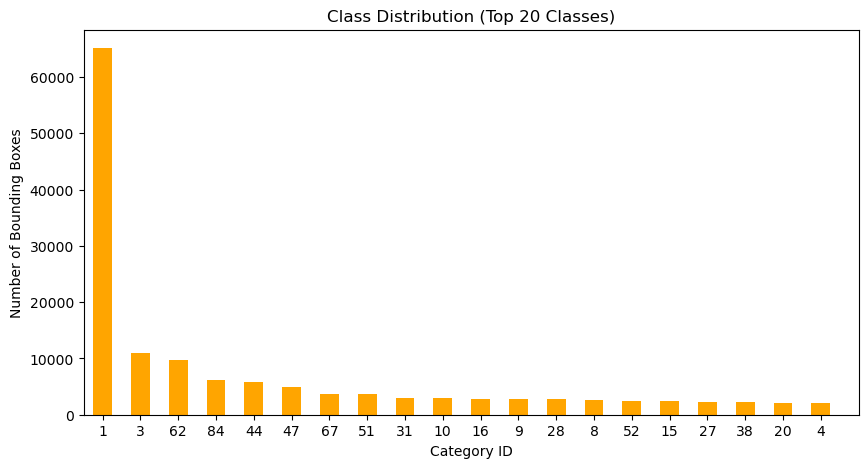

Category Mapping:
1 -> person, 2 -> bicycle, 3 -> car, 4 -> motorcycle, 5 -> airplane, 6 -> bus, 7 -> train, 8 -> truck, 9 -> boat, 10 -> traffic light, 11 -> fire hydrant, 13 -> stop sign, 14 -> parking meter, 15 -> bench, 16 -> bird, 17 -> cat, 18 -> dog, 19 -> horse, 20 -> sheep, 21 -> cow, 22 -> elephant, 23 -> bear, 24 -> zebra, 25 -> giraffe, 27 -> backpack, 28 -> umbrella, 31 -> handbag, 32 -> tie, 33 -> suitcase, 34 -> frisbee, 35 -> skis, 36 -> snowboard, 37 -> sports ball, 38 -> kite, 39 -> baseball bat, 40 -> baseball glove, 41 -> skateboard, 42 -> surfboard, 43 -> tennis racket, 44 -> bottle, 46 -> wine glass, 47 -> cup, 48 -> fork, 49 -> knife, 50 -> spoon, 51 -> bowl, 52 -> banana, 53 -> apple, 54 -> sandwich, 55 -> orange, 56 -> broccoli, 57 -> carrot, 58 -> hot dog, 59 -> pizza, 60 -> donut, 61 -> cake, 62 -> chair, 63 -> couch, 64 -> potted plant, 65 -> bed, 67 -> dining table, 70 -> toilet, 72 -> tv, 73 -> laptop, 74 -> mouse, 75 -> remote, 76 -> keyboard, 77 -> cell 

In [63]:
# Dictionary to map category ID to number of bounding boxes
class2nboxes = {}

for ann in coco1.dataset['annotations']:
    cat_id = ann['category_id']
    class2nboxes[cat_id] = class2nboxes.get(cat_id, 0) + 1 

# Sort categories by the number of bounding boxes in descending order
sorted_c2nb = sorted(class2nboxes.items(), key=lambda item: item[1], reverse=True)

# Select top 20 classes (or total available)
top = min(len(sorted_c2nb), 20)

# Extract data for plotting
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(y)), y, width=0.5, tick_label=x, color='orange')
plt.xlim(-0.5, len(y))
plt.xlabel('Category ID')
plt.ylabel('Number of Bounding Boxes')
plt.title('Class Distribution (Top 20 Classes)')
plt.show()

# Mapping category IDs to category names
categ_map = {x['id']: x['name'] for x in coco1.dataset['categories']}

# Print category mapping
print("Category Mapping:")
print(", ".join([f"{k} -> {v}" for k, v in categ_map.items()]))


## Least and Most Common objects

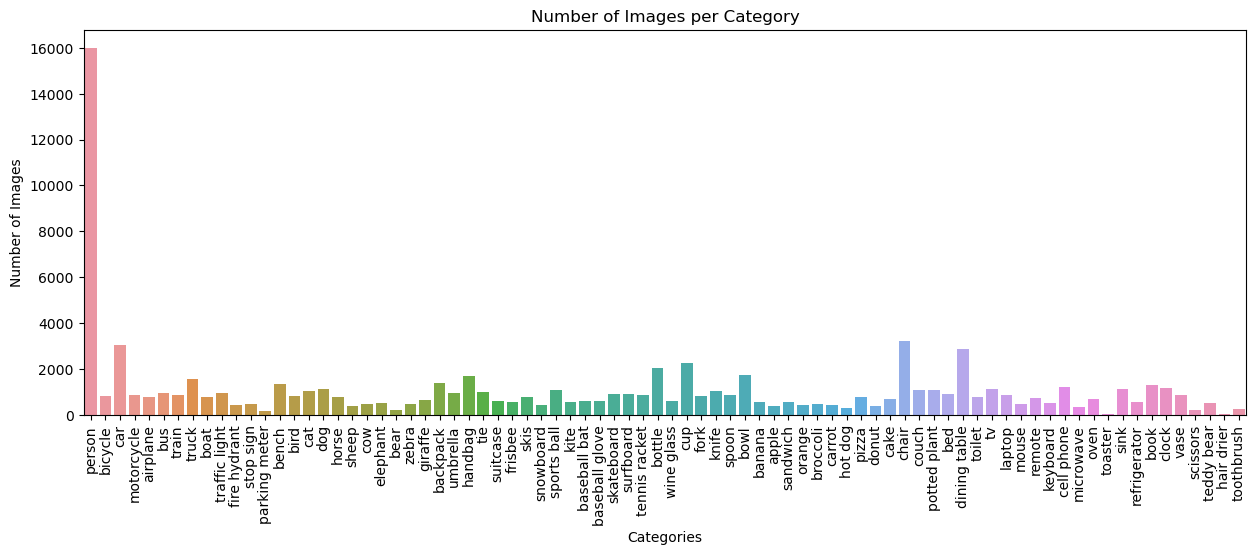

Most Common Category: ('person', 15978)
Least Common Category: ('hair drier', 36)


In [64]:
# Find the most and least common objects

# Count the number of images for each category
category_image_counts = {}
for cat_id in category_ids:
    img_ids = coco1.getImgIds(catIds=[cat_id])
    category_image_counts[coco1.loadCats([cat_id])[0]['name']] = len(img_ids)

# Plot category counts
plt.figure(figsize=(15, 5))
sns.barplot(x=list(category_image_counts.keys()), y=list(category_image_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Number of Images per Category")
plt.show()

sorted_categories = sorted(category_image_counts.items(), key=lambda x: x[1], reverse=True)
print("Most Common Category:", sorted_categories[0])
print("Least Common Category:", sorted_categories[-1])


## Viewing Random Image

Detected classes: ['wine glass', 'cup', 'cup', 'cup', 'knife', 'bowl', 'sink', 'wine glass', 'cup', 'cup', 'bowl', 'cup', 'bottle']


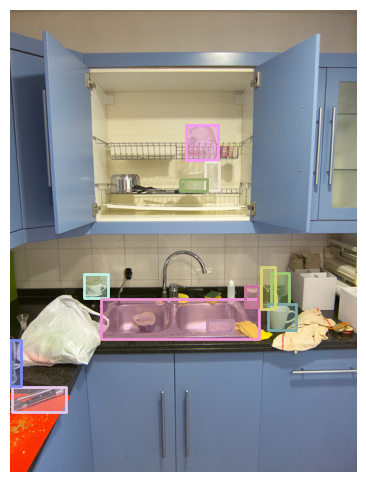

In [65]:
from skimage import io
import random

# Get all image and category IDs
img_ids = coco1.getImgIds()
cat_ids = coco1.getCatIds()

# Select a random image from the dataset
img = coco1.loadImgs(random.choice(img_ids))[0]
img_path = os.path.join(IMAGE_FOLDER, img['file_name'])

# Load the image using skimage
I = io.imread(img_path)

# Plot image
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(I)

# Get annotation IDs for the selected image
ann_ids = coco1.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco1.loadAnns(ann_ids)

# Disable segmentation (empty segmentation list)
for a in anns:
    a['segmentation'] = []

# Display annotations (bounding boxes)
coco.showAnns(anns, draw_bbox=True)

# Get class names for detected objects
class_names = [coco1.loadCats([a['category_id']])[0]['name'] for a in anns]
print("Detected classes:", class_names)

## Image Resolution Distribution

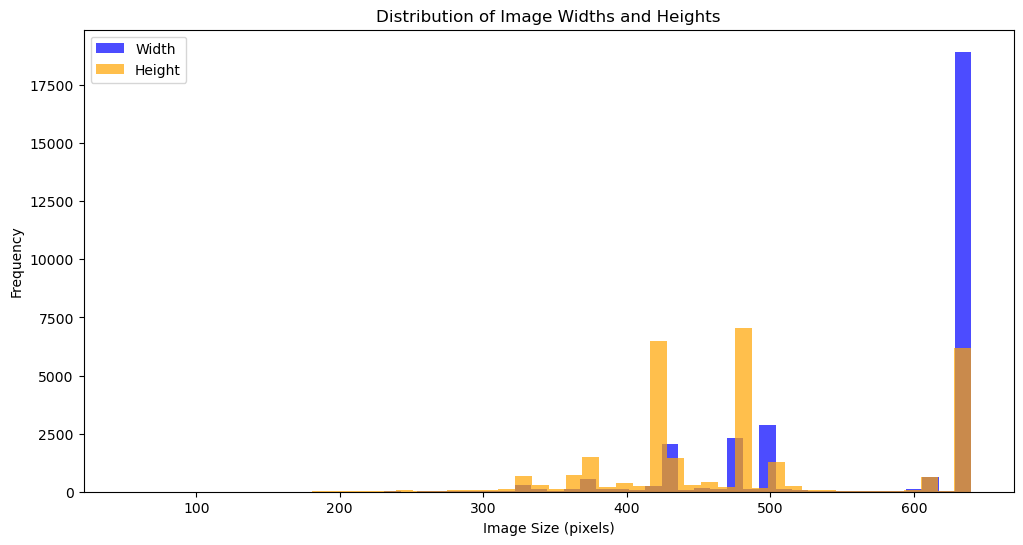

Mean Image Width: 577.51 pixels
Mean Image Height: 483.88 pixels
Median Image Width: 640.00 pixels
Median Image Height: 480.00 pixels
Min Image Size: 72 x 51 pixels
Max Image Size: 640 x 640 pixels


In [66]:
# Get image metadata
image_metadata = coco1.loadImgs(coco.getImgIds())

# Extract image widths and heights
image_sizes = [(img['width'], img['height']) for img in image_metadata]

# Convert to numpy array
image_sizes = np.array(image_sizes)

# Plot distribution of image sizes
plt.figure(figsize=(12,6))
plt.hist(image_sizes[:,0], bins=50, alpha=0.7, label="Width", color='blue')
plt.hist(image_sizes[:,1], bins=50, alpha=0.7, label="Height", color='orange')
plt.xlabel("Image Size (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Widths and Heights")
plt.legend()
plt.show()

# Print basic statistics
width_mean, height_mean = np.mean(image_sizes, axis=0)
width_median, height_median = np.median(image_sizes, axis=0)
width_min, height_min = np.min(image_sizes, axis=0)
width_max, height_max = np.max(image_sizes, axis=0)

print(f"Mean Image Width: {width_mean:.2f} pixels")
print(f"Mean Image Height: {height_mean:.2f} pixels")
print(f"Median Image Width: {width_median:.2f} pixels")
print(f"Median Image Height: {height_median:.2f} pixels")
print(f"Min Image Size: {width_min} x {height_min} pixels")
print(f"Max Image Size: {width_max} x {height_max} pixels")


## Bounding Box Analysis

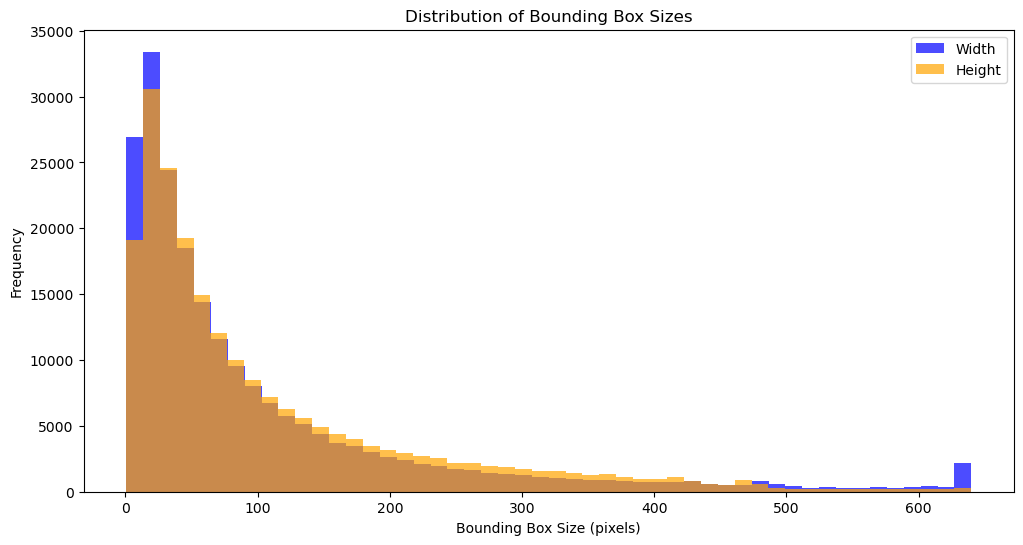

Mean Bounding Box Width: 104.14 pixels
Mean Bounding Box Height: 107.58 pixels
Median Bounding Box Width: 54.35 pixels
Median Bounding Box Height: 62.50 pixels


In [67]:
# Get all annotations
annotations = coco1.loadAnns(coco1.getAnnIds())

# Extract bounding box widths and heights
bbox_sizes = [(ann['bbox'][2], ann['bbox'][3]) for ann in annotations]

# Convert to numpy array
bbox_sizes = np.array(bbox_sizes)

# Plot distribution of bounding box widths and heights
plt.figure(figsize=(12,6))
plt.hist(bbox_sizes[:,0], bins=50, alpha=0.7, label="Width", color='blue')
plt.hist(bbox_sizes[:,1], bins=50, alpha=0.7, label="Height", color='orange')
plt.xlabel("Bounding Box Size (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Sizes")
plt.legend()
plt.show()

# Print basic statistics
width_mean, height_mean = np.mean(bbox_sizes, axis=0)
width_median, height_median = np.median(bbox_sizes, axis=0)

print(f"Mean Bounding Box Width: {width_mean:.2f} pixels")
print(f"Mean Bounding Box Height: {height_mean:.2f} pixels")
print(f"Median Bounding Box Width: {width_median:.2f} pixels")
print(f"Median Bounding Box Height: {height_median:.2f} pixels")


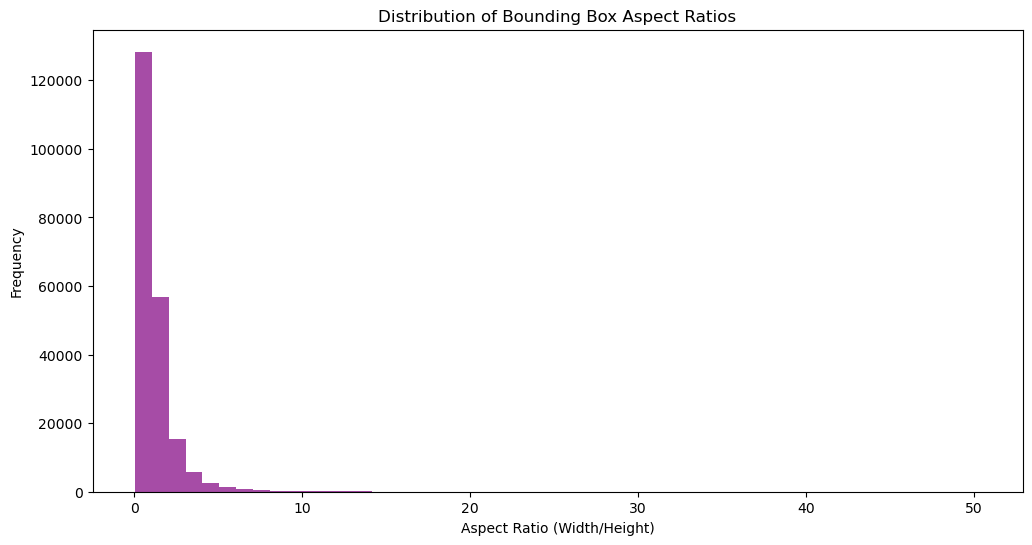

Mean Aspect Ratio: 1.22
Median Aspect Ratio: 0.87


In [68]:
# Compute aspect ratios (width/height)
aspect_ratios = bbox_sizes[:,0] / (bbox_sizes[:,1] + 1e-6)  # Avoid division by zero

# Plot histogram
plt.figure(figsize=(12,6))
plt.hist(aspect_ratios, bins=50, color='purple', alpha=0.7)
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Aspect Ratios")
plt.show()

# Print aspect ratio statistics
aspect_ratio_mean = np.mean(aspect_ratios)
aspect_ratio_median = np.median(aspect_ratios)

print(f"Mean Aspect Ratio: {aspect_ratio_mean:.2f}")
print(f"Median Aspect Ratio: {aspect_ratio_median:.2f}")


## Resizing

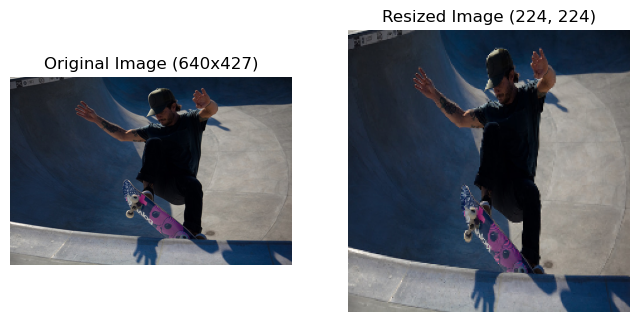

In [69]:
def resize_coco_image(coco, img_id, target_size=(224, 224)):
    # Load image metadata
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGE_FOLDER, img_info['file_name'])  

    
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image {img_path}")
        return None
    
    # Get original size
    original_size = (img_info['width'], img_info['height'])
    
    # Resize the image
    resized = cv2.resize(image, target_size)

    # Display original and resized images
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image ({original_size[0]}x{original_size[1]})")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Resized Image {target_size}")
    axes[1].axis("off")

    plt.show()
    
    return resized


random_img_id = random.choice(coco1.getImgIds())
resized_img = resize_coco_image(coco1, random_img_id)

## Grayscale Image

Converted to Grayscale - Shape: (447, 640)


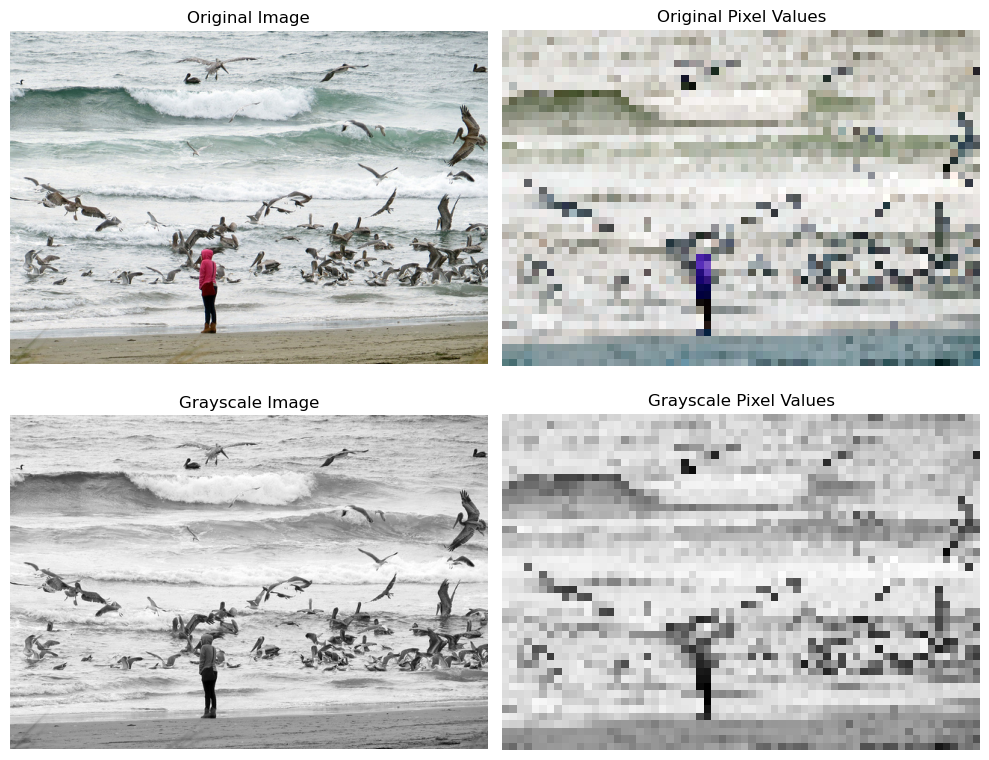

In [70]:
def convert_to_grayscale(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(f"Converted to Grayscale - Shape: {grayscale.shape}")
   
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
  
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")
  
    axes[0, 1].imshow(image[::10, ::10])  
    axes[0, 1].set_title("Original Pixel Values")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(grayscale, cmap='gray')
    axes[1, 0].set_title("Grayscale Image")
    axes[1, 0].axis("off")

    # Grayscale pixel values 
    grayscale_values = grayscale[::10, ::10] 
    axes[1, 1].imshow(grayscale_values, cmap='gray')
    axes[1, 1].set_title("Grayscale Pixel Values")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    return grayscale


def process_random_coco_image(coco1):
    
    random_img_id = random.choice(coco1.getImgIds())

    # Load image metadata
    img_info = coco1.loadImgs(random_img_id)[0]
    img_path = os.path.join(IMAGE_FOLDER, img_info['file_name'])

    # Load image using OpenCV
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image {img_path}")
        return None

    # Convert to grayscale
    grayscale_img = convert_to_grayscale(image)
    
    return grayscale_img


grayscale_img = process_random_coco_image(coco1)
